# Preclustering and Cluster Enriched Features

## Purpose
The purpose of this step is to perform a simple pre-clustering using the highly variable features to get a pre-clusters labeling. We then select top enriched features for each cluster (CEF) for further analysis.

## Input
- HVF adata file.

## Output
- HVF adata file with pre-clusters and CEF annotated.

## Import

In [1]:
import yaml
import anndata
import scanpy as sc
import pandas as pd
from ALLCools.clustering import cluster_enriched_features, significant_pc_test, log_scale

## Parameters

In [2]:
with open('config/04a.yaml', 'r') as f:
    config = yaml.safe_load(f)
    locals().update(config)
    print('Notebook configs:')
    for _k, _v in config.items():
        print(f'{_k} = {_v}')

Notebook configs:
adata_path = mCH.HVF.h5ad
alpha = 0.05
cluster_col = None
cluster_plot = False
downsample = 1000
knn = 25
resolution = 1
stat_plot = True
top_n = 200


In [3]:
# Parameters
adata_path = "mCH.HVF.h5ad"
alpha = 0.05
cluster_col = None
cluster_plot = False
downsample = 1000
knn = 25
resolution = 1
stat_plot = True
top_n = 200


## Load Data

In [4]:
adata = anndata.read_h5ad(adata_path)

## Pre-Clustering

If cluster label is not provided, will perform basic clustering here

In [5]:
if cluster_col is None:
    # IMPORTANT
    # put the unscaled matrix in adata.raw
    adata.raw = adata
    log_scale(adata)
    
    sc.tl.pca(adata, n_comps=min(min(adata.shape) - 1, 100))
    significant_pc_test(adata, p_cutoff=0.1, update=True)
    
    sc.pp.neighbors(adata, n_neighbors=knn)
    sc.tl.leiden(adata, resolution=resolution)
    
    if cluster_plot:
        sc.tl.umap(adata)
        sc.pl.umap(adata, color='leiden')
    
    # return to unscaled X, CEF need to use the unscaled matrix
    adata = adata.raw.to_adata()
    del adata.uns['log']
    
    cluster_col = 'leiden'

38 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (12291, 100) to (12291, 38)


## Downsample if the adata is too large

In [6]:
if downsample is not None:
    use_cells = []
    for cluster, sub_df in adata.obs.groupby(cluster_col):
        if sub_df.shape[0] > downsample:
            cells = sub_df.sample(downsample).index
        else:
            cells = sub_df.index
        use_cells += cells.tolist()
    use_adata = adata[pd.Index(use_cells), :].copy()
else:
    use_adata = adata

## Cluster Enriched Features (CEF)

Found 33 clusters to compute feature enrichment score
Computing enrichment score


Computing enrichment score FDR-corrected P values


Selected 2244 unique features


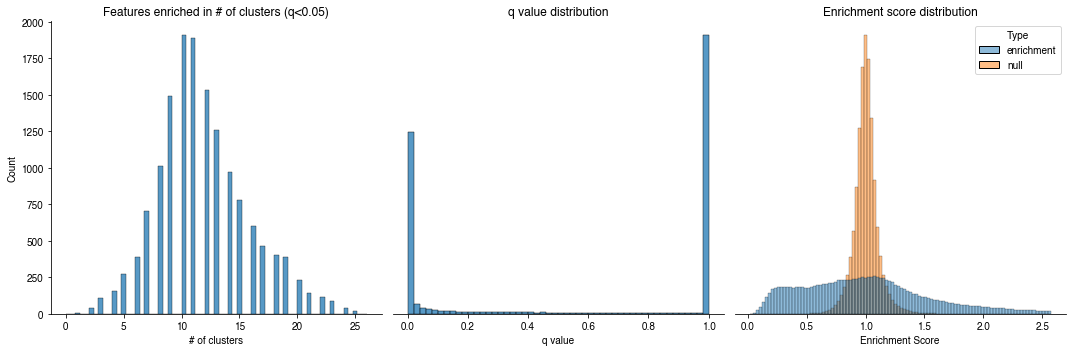

In [7]:
cluster_enriched_features(use_adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)

In [8]:
if downsample is not None:
    adata.uns[f'{cluster_col}_feature_enrichment'] = use_adata.uns[f'{cluster_col}_feature_enrichment']
    adata.var[f'{cluster_col}_enriched_features'] = use_adata.var[f'{cluster_col}_enriched_features']
else:
    adata = use_adata

## Save AnnData

In [9]:
adata = adata[:, adata.var[f'{cluster_col}_enriched_features']]
adata.write_h5ad('mCH.CEF.h5ad')